
# Recursive Bayes Filter - Lab 7.1

## Recap

This is the Lab on using a Recursive Bayes Filter in CE6003's Object Tracking. You should complete the tasks in this lab as part of the Bayes section of the lesson.

Please remember this lab must be completed before taking the quiz at the end of this lesson.

First, if we haven't already done so, we need to clone the various images and resources needed to run these labs into our workspace.


In [1]:
!git clone https://github.com/EmdaloTechnologies/CE6003.git

Cloning into 'CE6003'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (33/33), done.
remote: Compressing objects: 100% (30/30), done.
remote: Total 620 (delta 6), reused 26 (delta 3), pack-reused 587
Receiving objects: 100% (620/620), 962.35 MiB | 42.89 MiB/s, done.
Resolving deltas: 100% (46/46), done.
Checking out files: 100% (540/540), done.


This program demonstrates a very simple 'tracking' mechanism - derived from a Bayesian approach.

It improves the estimate for the position of a static object (e.g. a car) as new position estimates (e.g. from a GPS system) arrives.

It illustrates the shape of the (x,y) measurements arriving to the algorithm as a histogram of x, a histogram of y - each with mean and variance, a scatter plot of the 'measurements' arriving and as a Co-variance of x and y.  These are terms and concepts we'll use throughout the lessons.

First, lets import our typical libaries; numpy, scipy, math for matrix maths, matplotlib, mplot3d for plotting

In [0]:
# Our imports
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D
import scipy.stats as stats
import os
import math
from IPython import display

%matplotlib inline

**Program Structure**

After visualising the input data, the program simply
loops for 'iterations' each time refining its position estimate based on an array of 'measurements', fed to it one at a time.

the actual position is 4,5 but the program doesn't know that
- instead it build a region where it becomes increasing confident that, for each update, the car should be (from a series of estimates centred around 4,5 where the estimation error is normal or gaussian)

In this example, this assumption is valid as the estimation error is defined as a gaussian around where the car actually is.



**Major Model Variables**

The major variables that control the model are:

**iterations:** how may times to run the model

**gridsize:** the size of the x-y grid to place the car in

**actual_pos:** where the car actually is on the grid

**variance:** the variance in the measurements (both in x and y)

In [0]:
# major model variables
iterations = 50         # number of iterations to run the model
gridsize=(40,40)        # the size of the grid containing our car
actual_pos = (4,5)      # the actual position of the car in the grid

variance = (2,2)        # the variances (in x and y) of the measurement estimates

**Estimates**

Create the estimates up front - ensure they are centred around actual_pos and the estimates vary in a gaussian manner with the variance defined above

In [0]:
estimates = np.zeros((iterations,2), dtype=float)
estimates[:,0] = np.random.normal(actual_pos[0], variance[0], iterations)
estimates[:,1] = np.random.normal(actual_pos[1], variance[1], iterations)

# Visualising the input data

This shows visualisations of the data. It illustrates the estimates as a histogram in x with mean and variance, a histogram in y with mean and variance and a scatter-plot showing the estimates centred around the 'actual' value of x,y.

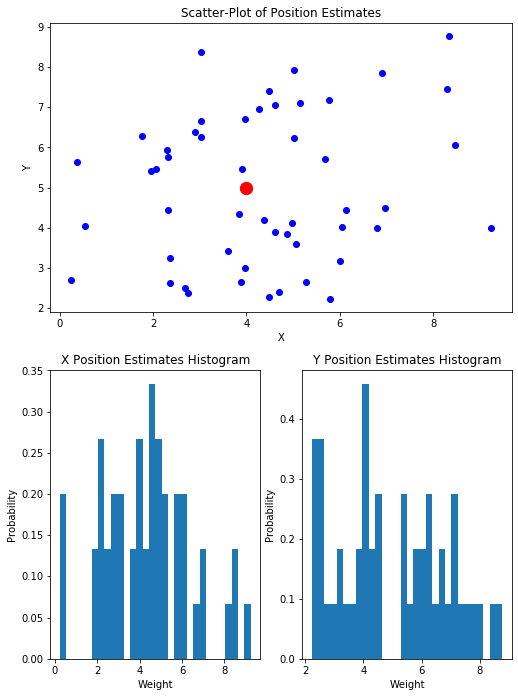

In [30]:
# create 2 x 2 sub plots

gs = gridspec.GridSpec(2,2)
plt.figure(figsize=np.array([210,297]) / 25.4)
ax = plt.subplot(gs[1, 0]) # row 1, col 0
ax.set_title('X Position Estimates Histogram')
ax.hist(estimates[:,0],density=True,bins=30)
ax.set(xlabel='Weight', ylabel = 'Probability')

ay = plt.subplot(gs[1,1]) # row 1, col 1
ay.set_title('Y Position Estimates Histogram')
ay.hist(estimates[:,1],density=True,bins=30)
ay.set(xlabel='Weight', ylabel = 'Probability')

sc = plt.subplot(gs[0, :]) # row 0, span all columns
sc.scatter(actual_pos[0], actual_pos[1],color='red', s=150)
sc.scatter(estimates[:,0],estimates[:,1],color='blue')
sc.set_title('Scatter-Plot of Position Estimates')
sc.set(xlabel = 'X', ylabel='Y')
plt.show()
plt.close('all')

**Position Estimates**

Here, we're forming an intuition about how the estimates will arrive, over time, to our Recursive Bayesian Filter.

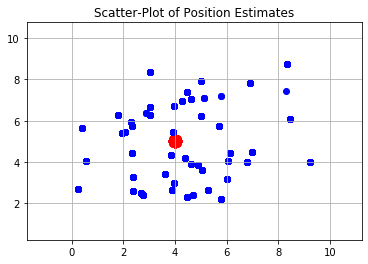

In [31]:
# Intuition as to how data will arrive into the algorithm
min_x = min(estimates[:,0])
max_x = max(estimates[:,0])
min_y = min(estimates[:,1])
max_y = max(estimates[:,1])
fig = plt.figure()

plt.grid(True)
plt.scatter(actual_pos[0], actual_pos[1],color='red', s=150)
scat = plt.scatter(estimates[:0,0],estimates[:0,1],color='blue')
plt.title('Scatter-Plot of Position Estimates')
plt.xlabel = 'X'
plt.ylabel='Y'
plt.xlim(min_x-2, max_x+2)
plt.ylim(min_y-2, max_y+2)

ax = fig.gca()

display.clear_output(wait=True)

for i in range(iterations):
        plt.grid(True)
        plt.scatter(actual_pos[0], actual_pos[1],color='red', s=150)
        plt.scatter(estimates[:i,0],estimates[:i,1],color='blue')
        plt.title('Scatter-Plot of Position Estimates')
        plt.xlabel = 'X'
        plt.ylabel='Y'
        plt.xlim(min_x-2, max_x+2)
        plt.ylim(min_y-2, max_y+2)
        display.display(plt.gcf())
        display.clear_output(wait=True)


**Covariance**

In this plot, we're going to visualise the covariance in the x and y terms of our estimates.

One key takeaway from this - before we run the estimates through our RBF is to note the spread of the variance.  We'll be hoping to show that the RBF reduces this variance.

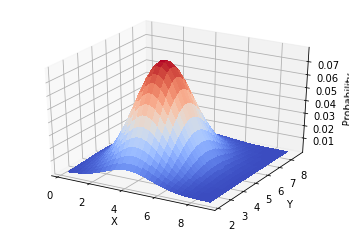

In [32]:
# Visualize the probabilities of the estimates
# as a 3D height map

fig = plt.figure()
ax = fig.gca(projection='3d')
hist, xedges, yedges = np.histogram2d(estimates[:,0], \
                                      estimates[:,1], bins=(30,30))
X, Y = np.meshgrid(xedges[:-1], yedges[:-1])
pos = np.empty(X.shape + (2,))
pos[:, :, 0] = X; pos[:, :, 1] = Y
rv = stats.multivariate_normal(actual_pos, \
                               [[variance[0], 0], [0, variance[1]]])
surf = ax.plot_surface(X,Y, rv.pdf(pos), \
                       cmap=cm.coolwarm, linewidth=0, antialiased=False)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Probability')

plt.show()


**Recursive Bayesian Filter (RBF)**

Now, we are going to iteratively solve:

$$\displaystyle P(A\mid B)={\frac {P(B\mid A)P(A)}{P(B)}} $$

where A and B are events (and P(B) is non-zero)

$P(A\mid B)$ is a *conditional probability*:

       what is the likelihood of seeing A given B is true

$P(B\mid  A)$ is also a *conditional probability*:

       what is the likelihood of B given a is true

P(A) and P(B) are the probabilities of seeing A and B independently of each other.

Or, put another way:

For each point in the grid, on the arrival of a new estimate, the probability that it is the 'right' point is affected by its old probability and how likely it is that it can account for the new estimate.

  $\displaystyle{post = \frac{(prior * likelihood)}{normalisation}}$

**Initialisation of Terms**

We're defining a prior term where we create a grid (in the shape of gridsize, one point for each position in the grid) and we initialise that to $\frac{1}{num-gridpoints}$, i.e. all squares in the grid are equally likely to be the correct square.

We create a post with the same shape as the prior and initialise it to the prior.

Now we want to handle the uncertainty in our state.  Effectively we're going to treat this as deciding how confident we are in our position relative to our measurement.

We create a co-variance term as a 2 by 2 matrix, looking like this:

$K = \begin{bmatrix}4 & 0 \\ 0 & 4\end{bmatrix}$

So, the first term only affects the x-term of our estimates and the second term only affects the y-term of our estimates and each term represents an variance of 4.

In [0]:
# Define a prior matrix with one point for every point
# on the grid.
prior = np.zeros(shape=gridsize)
# nothing is known at this stage so all squares are equally likely
# initialise all with same probability (1 / num squares)
prior = prior + 1/np.sum(gridsize)

# Create a post matrix
post = np.zeros(shape=gridsize)
# set to same value as priors for now
post = prior

# define a covariance matrix K for making a 2-D Gaussian variance
K = [ (0.4, 0), (0, 0.4)]

**Exercise 1**

Adjust the measurement co-variance in the K term above and monitor its affect in the animation below. For example, multiply by 10 and divide by 10.

**Exercise 2**
Adjust the *variance* term $(2,2)$ above and monitor its affect on the animation below.

**Insight**
These two exercises illustrate the key relationship in the RCF - the impact of the variance of position estimate vs measurement variance on the behaviour of the model.

**Exercise 3**
Generate the position estimates differently.  Instead of 200 estimates around a single mean, create 100 estimates around one mean (e.g. 5,4) and append another 100 estimates around a second mean (e.g. 4,5).  Observe how the filter copes with this.

**Insight**
The insight here is that we can see a route where we can use the RCF (or a variation thereof) to take account of a moving object.

**Grid Adjustment**

To make the grid more generic, we leave the grid based on the size of grid in gridsize, but we set the range and interval of the grid to something sensible, for instance we could say that our grid consists of 40 values in x and 40 values in y; and that the values start at half the value of the x-value we are estimating and the x values end at 1.5 times the x-value we are estimating and that the interval is linear between these two values.

In [0]:
# define a grid (defined as gridsize), initialise all points
x_range = np.zeros(gridsize[0])
y_range = np.zeros(gridsize[1])

# initialise x_range with values from x0 .. X .. xn such that 
# actual_pos is in the middle of the grid and the grid is
# scaled in a reasonable manner
min_x = actual_pos[0] - (actual_pos[0])/2
max_x = actual_pos[0] + (actual_pos[0])/2
step_x = (max_x - min_x) / gridsize[0]
for i in range(gridsize[0]):
        x_range[i] = min_x + i*step_x

# initialise y_range with values from y0 .. Y .. yn such 
# that actual_pos is in the middle and the grid is scaled in
# a reasonable manner
min_y = actual_pos[1] - (actual_pos[1])/2
max_y = actual_pos[1] + (actual_pos[1])/2
step_y = (max_y - min_y) / gridsize[1]
for i in range(gridsize[1]):
        y_range[i] = min_y + i*step_y

**Main Loop of Recursive Bayesian Filter**

On each iteration, this visits each square on the grid and determines how likely that this point is to be 'correct', given the new estimate.

We multiply that likelihood term by the square's prior - effectively a measure of how 'confident' the square was that it was the 'correct' square.

We crudely normalise the $(prior \times likelihood)$ term, by normalising to 1. Simply sum all $(prior \times likelihood)$ terms in the grid and divide each $(prior \times likelihood)$ term by the sum.  

Re-summing will now equal to 1 - so we've crudely converted back into a probability distribution - effectively now we can recurse infinitely.

Compute likelihood of receiving a measurement at using the normal distribution function

${P(x|\mu,\sigma^2) = \frac{1}{\sqrt{2\pi\sigma^2}} e^\frac{-(x - \mu)^2}{2\sigma^2}}$

We'll compute the likelihood of x and y separately, deriving our variance from the K matrix and multiply.

We'll approximate the shape of the Gaussian by using $abs(x-\mu)$ instead of $\frac{(x-\mu)^2}{2\sigma^2}$

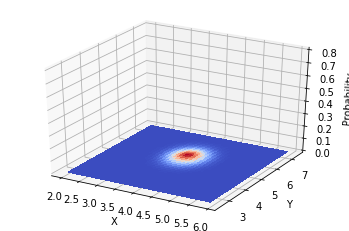

In [41]:

display.clear_output(wait=True)

#
# On each iteration:
#       For each point:
#               How likely is it that this point can 'explain' the new estimate
#               Multiply that by how confident the point was
#
#       Convert all new values to a prob dist by ensuring they total to 1.
#
for iteration in range(iterations):
        prior = post    # store the (old) post to the prior
        m = 0 * prior   # m is our working area and starts at zero

        # likelihood algorithm
        #       look at each location.
        #       assume that location is the correct location
        #       get the likelihood of the point accounting for the
        #       estimate  assuming 2-D gaussian noise
        for i in range(gridsize[0]):
                for j in range(gridsize[1]):
                        # compute likelihood

                        # this represents where we 'think' we are
                        pos = (x_range[i], y_range[j])

                        likelihood = ( (1 / (np.sqrt((2*(np.pi)**2)))) * np.linalg.det(K) * np.exp(-(((estimates[iteration]-pos)**2)/2*(np.linalg.det(K)))))
                             #( (1 / (np.sqrt((2*(np.pi)**2)))) * \
                             #np.linalg.det(K) * \
                             #np.exp(-(((estimates[iteration]-pos)**2)/2*(K))))))
                             #np.exp(-(np.absolute(estimates[iteration]-pos))))
                            
                        # how likely we are to see this estimate
                        m[i,j] = likelihood[0]*likelihood[1]

                        ## combine this likelihood with prior confidence
                        m[i,j] = m[i,j] * prior[i,j]

        # normalise this distribution to make it
        # a probability distribution
        post = m / np.sum(m)
        
        # Pretty pictures - plot Post
        fig = plt.figure()
        ax = fig.gca(projection='3d')
        x = x_range
        y = y_range

        X, Y = np.meshgrid(x, y)
        surf = ax.plot_surface(X,Y, post, cmap=cm.coolwarm, linewidth=0, antialiased=False)
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Probability')
        ax.set_zlim(0,0.8)

        display.display(plt.gcf())
        display.clear_output(wait=True)

plt.close('all')


*Conclusion*

The key takeaways are:

1. We have introduced the concept that we are treating our position and our estimates as probability terms - defined by their mean and variance (standard deviation squared).
2. We have the developed the concept of using Bayes Theorem to successively improve an estimate
3. We have applied that insight to locating a static object, iteratively using uncertain initial position and uncertain measurements.
4. We have gained the insight that one or two 'poor' measurements do not significantly adjust our position confidence.
5. We have introduced three key terms - $posterior$ or $post$ $prior$ and $measurement$, where each term is essentially conceived as a mean and variance about that mean of that term.  We're treating $prior$ as essentially confidence in position before $measurement$ arrival, $measurement$ as essentially a confidence in a measurement, and $post$ as essentially a new confidence in position after $measurement$.

*Next Steps*
1. Kalman Filters
2. Particle Filters